In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('spam.csv', encoding='Windows-1252')

data = pd.concat([data, pd.get_dummies(data['v1'], prefix='label', drop_first=True)], axis=1)
data['label'] = data['v1']
data['text'] = data['v2']
data = data.drop(columns=['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

data

,label_spam,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,0,ham,Ok lar... Joking wif u oni...
2,1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,ham,U dun say so early hor... U c already then say...
4,0,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,1,spam,This is the 2nd time we have tried 2 contact u...
5568,0,ham,Will Ì_ b going to esplanade fr home?
5569,0,ham,"Pity, * was in mood for that. So...any other s..."
5570,0,ham,The guy did some bitching but I acted like i'd...


Label distribution: 747 4825


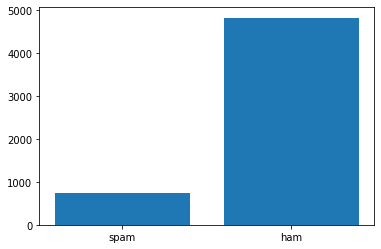

In [3]:
total_count = len(data['label_spam'].values)
spam_count = len(data[data['label_spam'] == 1].values)

print('Label distribution:', spam_count, total_count - spam_count)

plt.bar(['spam', 'ham'], [spam_count, total_count - spam_count])
plt.show()

In [11]:
import cleantext

data['text'] = data['text'].apply(lambda text: cleantext.clean(text, all=False, extra_spaces=True, stemming=False, stopwords=False, lowercase=True, numbers=True, punct=True))

data

,label_spam,label,text
0,0,ham,go until jurong point crazy available only in ...
1,0,ham,ok lar joking wif u oni
2,1,spam,free entry in a wkly comp to win fa cup final...
3,0,ham,u dun say so early hor u c already then say
4,0,ham,nah i dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,spam,this is the nd time we have tried contact u u...
5568,0,ham,will ì b going to esplanade fr home
5569,0,ham,pity was in mood for that soany other suggest...
5570,0,ham,the guy did some bitching but i acted like id ...


Words: 85837
Unique words: 8618


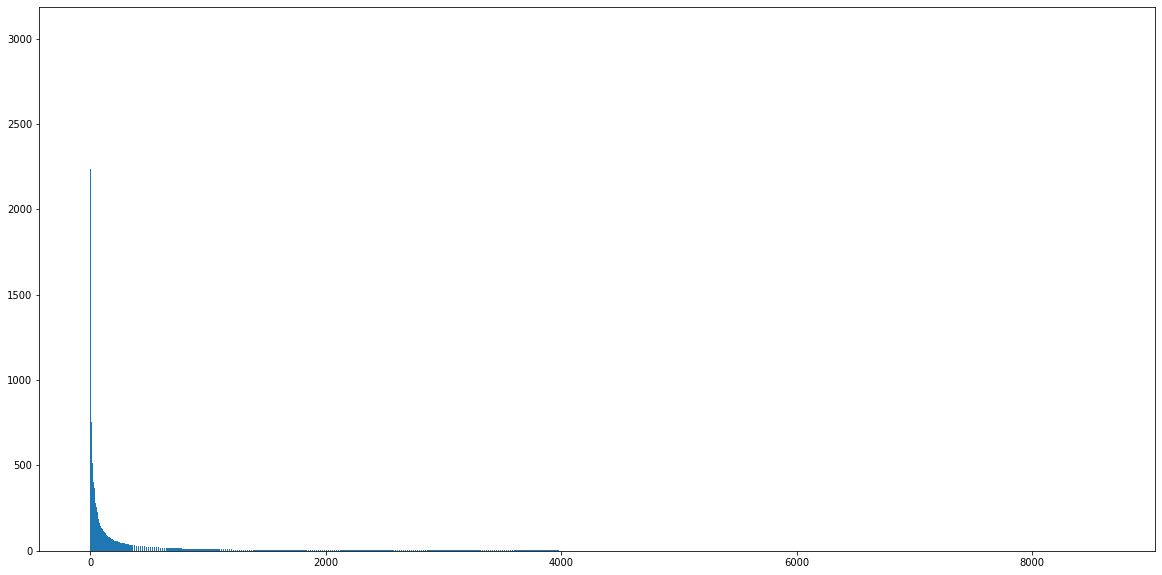

In [55]:
words = [ word for row in data['text'].values for word in row.split(' ') ]

unique_words = set(words)

print('Words:', len(words))
print('Unique words:', len(unique_words))

from collections import Counter

word_counter = Counter(words)

word_counter

word_count_list = [ (word, count) for word, count in word_counter.items() ]
word_count_list.sort(key=lambda x: x[1], reverse=1)

plt.figure(figsize=(20,10))
plt.bar(range(len(word_count_list)), [ count for (word, count) in word_count_list ])
plt.show()

In [58]:
counts = np.array([ count for (word, count) in word_count_list ])

count_data = pd.DataFrame(counts)
count_data.describe()

,0
count,8618.000000
mean,9.960200
std,69.781779
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,3033.000000


In [75]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(data['text'].values).toarray()
y = data['label_spam'].values

y

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

print(X_train.shape, X_validate.shape, X_test.shape)
print(y_train.shape, y_validate.shape, y_test.shape)

(4512, 8562) (502, 8562) (558, 8562)
(4512,) (502,) (558,)


In [111]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)

print('Accuracy:', xgb_classifier.score(X_validate, y_validate))

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:47:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9701195219123506


In [110]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

print('Accuracy:', random_forest.score(X_validate, y_validate))

Accuracy: 0.9581673306772909


Errors: 11 Accuracy: 0.9701195219123506
F1 score: 0.9799663237771522
Precision: 0.953125
Recall: 0.8840579710144928


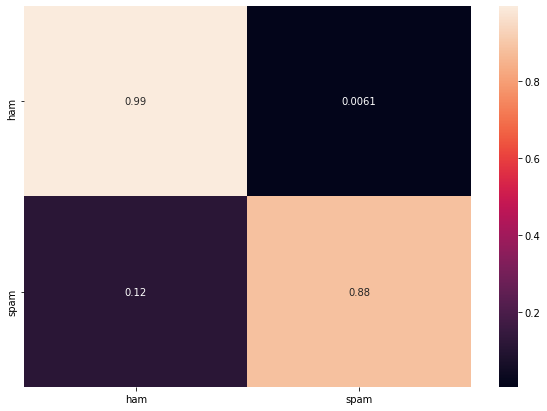

In [109]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sn

y_pred = xgb_classifier.predict(X_test)

print('Accuracy:', xgb_classifier.score(X_test, y_test))

confusion = confusion_matrix(y_test, y_pred, normalize='true')

confusion_data = pd.DataFrame(confusion, index = ['ham', 'spam'], columns = ['ham', 'spam'])
plt.figure(figsize = (10,7))
sn.heatmap(confusion_data, annot=True)

print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))            

Accuracy: 0.9695340501792115
F1 score: 0.9676541420333695
Precision: 1.0
Recall: 0.7536231884057971


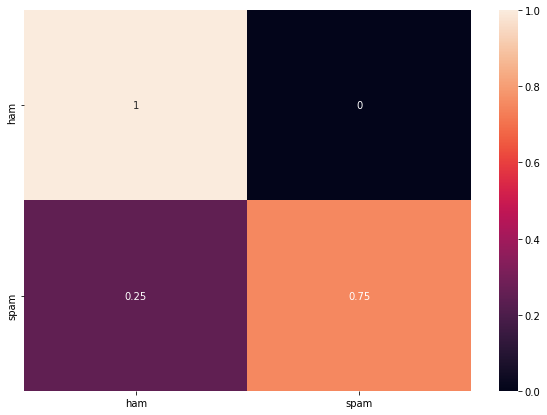

In [112]:
y_pred = random_forest.predict(X_test)

print('Accuracy:', random_forest.score(X_test, y_test))

confusion = confusion_matrix(y_test, y_pred, normalize='true')

confusion_data = pd.DataFrame(confusion, index = ['ham', 'spam'], columns = ['ham', 'spam'])
plt.figure(figsize = (10,7))
sn.heatmap(confusion_data, annot=True)

print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

In [2]:
import chardet
with open('spam.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}

In [78]:
!python3.8 -m pip install cleantext xgboost

     |████████████████████████████████| 1.2 MB 4.1 MB/s eta 0:00:01


In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hagenschupp/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text_train, text_test, label_train, label_test = train_test_split(data['text'].values, data['label_spam'].values, test_size=0.1, random_state=42)

input_train = tokenizer.batch_encode_plus(text_train, max_length=32, truncation=True, add_special_tokens=True, padding='max_length', return_attention_mask=True, return_token_type_ids=True, return_tensors = 'tf').values()
input_test = tokenizer.batch_encode_plus(text_test, max_length=32, truncation=True, add_special_tokens=True, padding='max_length', return_attention_mask=True, return_token_type_ids=True, return_tensors = 'tf').values()

In [23]:
input_test

dict_values([<tf.Tensor: shape=(558, 32), dtype=int32, numpy=
array([[ 101, 6057, 2755, ...,    0,    0,    0],
       [ 101, 1045, 2741, ..., 1037, 2470,  102],
       [ 101, 2057, 2113, ...,    0,    0,    0],
       ...,
       [ 101, 4283, 2005, ...,    0,    0,    0],
       [ 101, 1055, 3362, ...,    0,    0,    0],
       [ 101, 2017, 3726, ..., 2287, 4312,  102]], dtype=int32)>, <tf.Tensor: shape=(558, 32), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(558, 32), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>])

In [47]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 4)

input_ids = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name='input_ids')
token_type_ids = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name='token_type_ids')
attention_mask = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name='attention_mask')

output = bert_model([input_ids, token_type_ids, attention_mask])[0]
output = tf.keras.layers.Dropout(rate=0.5)(output)
output = tf.keras.layers.Dense(2)(output)

model = tf.keras.models.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 109485316   input_ids[0][0]                  
                                                                 token_type_ids[0][0]       

In [48]:
model(tokenizer.batch_encode_plus(text_train[0:8], max_length=32, truncation=True, add_special_tokens=True, padding='max_length', return_attention_mask=True, return_token_type_ids=True, return_tensors = 'tf').values())

<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[ 0.21464545,  0.3124826 ],
       [-0.4139619 , -0.34781888],
       [-0.3418876 , -0.26795396],
       [-0.30020022, -0.28078294],
       [-0.09826991,  0.20243052],
       [-0.27146122, -0.27404127],
       [-0.0587128 ,  0.26854178],
       [-0.44436574, -0.15231723]], dtype=float32)>

In [49]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.5784494693124135, 1: 3.6867647058823527}

In [39]:
class_weights

{0: 0.5784494693124135, 1: 3.6867647058823527}

In [50]:
history = model.fit(x=input_train, y=label_train, epochs=1, batch_size=32, validation_split=0.1, class_weight=class_weights)

141/141 [==============================] - 1419s 10s/step - loss: 0.3188 - accuracy: 0.9198 - val_loss: 0.1680 - val_accuracy: 0.9502


In [54]:
outputs = model(input_test)

labels_out = np.argmax(outputs.numpy(), axis=1)

F1 score: 0.8533333333333334


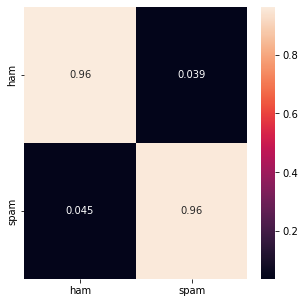

In [63]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sn

confusion = confusion_matrix(label_test, labels_out, normalize='true')

confusion_data = pd.DataFrame(confusion, index = ['ham', 'spam'], columns = ['ham', 'spam'])
plt.figure(figsize = (5,5))
sn.heatmap(confusion_data, annot=True)

print('F1 score:', f1_score(label_test, labels_out))

In [78]:
wrong_classified[0][0]

37

In [80]:
wrong_classified = np.where(labels_out != label_test)[0]

for index in wrong_classified:
    print('Text:', text_test[index], 'Prediction:', labels_out[index], 'True:', label_test[index])

Text: hey mate spoke to the mag people we‰û÷re on the is deliver by the end of the month deliver on the th sept talk later Prediction: 1 True: 0
Text: as per your request maangalyam alaipayuthe has been set as your callertune for all callers press  to copy your friends callertune Prediction: 1 True: 0
Text: wiskey brandy rum gin beer vodka scotch shampain wine kudiyarasu dhina vaazhthukkal Prediction: 1 True: 0
Text: appledayno doctor tulsi leafdayno cancer lemondayno fat cup milkdayno bone problms  litres watrdayno diseases snd ths  whom u care Prediction: 1 True: 0
Text: rose needs water season needs change poet needs imaginationmy phone needs ur sms and i need ur lovely frndship forever Prediction: 1 True: 0
Text: no dude its not fakemy frnds got money thts y im reffering uif u member wit my mail link u vl be credited ltgt rs and il be getiing ltgt rsi can draw my acc wen it is ltgt rs Prediction: 1 True: 0
Text: ringtoneking Prediction: 0 True: 1
Text: urgh coach hot smells of chip

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hagenschupp/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [61]:
!pip install sklearn transformers cleantext numpy pandas seaborn

     |████████████████████████████████| 292 kB 4.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
